In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import *
import time
import os
from torch.utils import data
import random
import copy
import itertools
import io

# Tensorboard for logging
from torch.utils.tensorboard import SummaryWriter



In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')
    
torch.cuda.set_device(1)
print(device)

cuda


In [3]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/andreasabo/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_100000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])
data_df.head

<bound method NDFrame.head of        image_ids     view_label  subj_id  view_train
0       1323_2_1        Missing     1323         NaN
1       1323_2_2        Missing     1323         NaN
2       1323_2_3        Missing     1323         NaN
3       1323_2_4        Missing     1323         NaN
4       1323_2_5        Missing     1323         NaN
...          ...            ...      ...         ...
72454  1066_7_50  Saggital_Left     1066         0.0
72455  1066_7_51  Saggital_Left     1066         0.0
72456  1066_7_52  Saggital_Left     1066         0.0
72457  1066_7_53  Saggital_Left     1066         0.0
72458  1066_7_54          Other     1066         0.0

[72459 rows x 4 columns]>

### **Hyperparameters**

In [4]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 48

# Number of epochs to train for
num_epochs = 200

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = False

### **Reading Data Indicies and Labels**

In [5]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

labels = {}
train_and_valid_subj_ids = []
train_and_valid_image_ids = []
test_ids = []

for ind, row in train_df.iterrows():
    train_and_valid_subj_ids.append(row['subj_id'])
    train_and_valid_image_ids.append(row['image_ids'])
    labels[row['image_ids']] = row['view_label']

for ind, row in test_df.iterrows():
    test_ids.append(row['image_ids'])
    labels[row['image_ids']] = row['view_label']

s = set()
t_v_ids = pd.DataFrame(list(zip(train_and_valid_subj_ids, train_and_valid_image_ids)), columns=['subj_ids', 'image_ids'])
id_groups = [t_v_ids for _, t_v_ids in t_v_ids.groupby('subj_ids')]
random.shuffle(id_groups)
id_groups = pd.concat(id_groups).reset_index(drop=True)
train_val_split = int(0.8*len(set(id_groups['subj_ids'].values)))
train_val_set = [i for i in id_groups['subj_ids'].values if not (i in s or s.add(i))]
cutoff = train_val_set[train_val_split]
train_portion = (id_groups['subj_ids'].values == cutoff).argmax()

train_ids = id_groups[:train_portion]['image_ids'].tolist()
valid_ids = id_groups[train_portion:]['image_ids'].tolist()

partition = {'train':train_ids, 'valid':valid_ids}

In [6]:
def plot_confusion_matrix_local(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [7]:
# https://www.tensorflow.org/tensorboard/image_summaries
# def plot_to_image(figure):
#   """Converts the matplotlib plot specified by 'figure' to a PNG image and
#   returns it. The supplied figure is closed and inaccessible after this call."""
#   # Save the plot to a PNG in memory.
#   buf = io.BytesIO()
#   plt.savefig(buf, format='png')
#   # Closing the figure prevents it from being displayed directly inside
#   # the notebook.
#   plt.close(figure)
#   buf.seek(0)
#   # Convert PNG buffer to TF image
#   image = tf.image.decode_png(buf.getvalue(), channels=4)
#   # Add the batch dimension
#   image = tf.expand_dims(image, 0)
#   return image

### **Model**

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, writer = None):
    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        labels = torch.argmax(labels, 1)
                        running_preds += torch.argmax(outputs, 1).tolist()
                        running_labels += labels.tolist()
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))
            # Log to tensorboard for visualization
            if writer is not None and phase == 'train':
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/train', figure, epoch)
                
                
                
            if writer is not None and phase == 'val':
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/val', figure, epoch)
            # deep copy the model
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(classification_report(running_labels, running_preds))
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

class ViewNet(nn.Module):

    
    def __init__(self, num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout):
        super(ViewNet, self).__init__()
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.conv3_filters = conv3_filters
        self.linear1_size = linear1_size
        self.drop_percent = dropout
        
        self.conv1 = nn.Conv2d(1, self.conv1_filters, 4, padding=2)
        self.conv2 = nn.Conv2d(self.conv1_filters, self.conv2_filters, 4, padding=2)
        self.conv3 = nn.Conv2d(self.conv2_filters, self.conv3_filters, 4, padding=2)
        self.pool = nn.MaxPool2d(4, 4)
        self.dropout = nn.Dropout(self.drop_percent)
        self.linear1 = nn.Linear(self.conv3_filters*4*4, self.linear1_size)
        self.dropout = nn.Dropout(self.drop_percent)
        self.linear2 = nn.Linear(self.linear1_size, num_classes)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = x.view(-1, self.conv3_filters*4*4) ## reshaping 
        x = self.dropout(F.relu((self.linear1(x))))
        x = self.linear2(x)
        return x



### **Data Loading**

In [11]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transformations=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transformations = transformations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path).convert('L')
        
        if self.transformations:
            image = self.transformations(image)
        
        
        image = ToTensor()(image)
        
        
        
        y = torch.FloatTensor([0]*6)        
        y[int(self.labels[ID])] = 1

        return image, y

In [12]:
# Data augmentation and normalization for training

# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
transformation = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])
# Generators
training_set = Dataset(partition['train'], labels, transformations = transformation)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['valid'], labels)
validation_generator = data.DataLoader(validation_set, **params)

dataloaders_dict = {'train':training_generator, 'val':validation_generator}

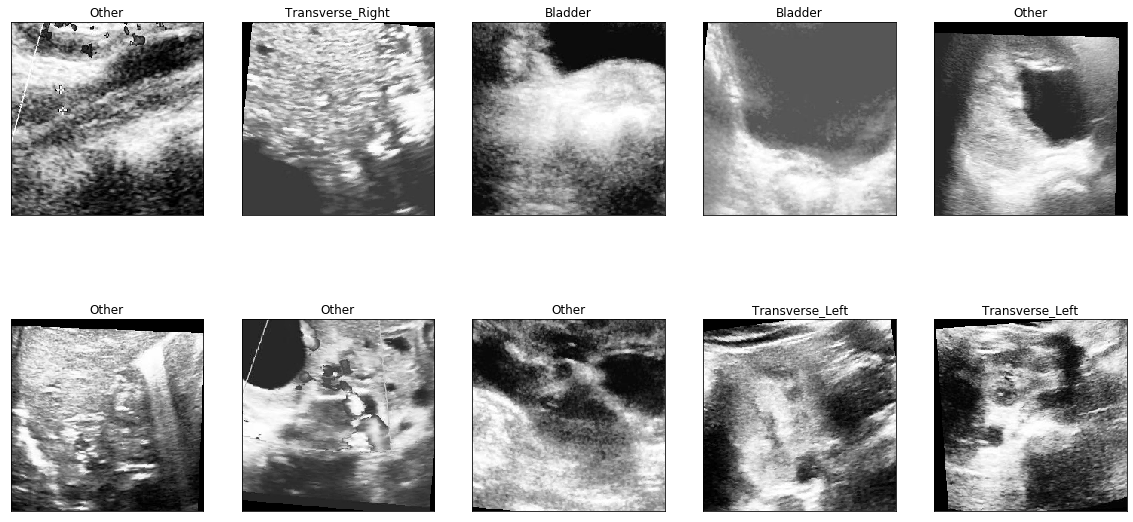

In [13]:
# Lets check that the data augmentation makes sense


for inputs, labs in training_generator:
#     plt.subplot(2,5)
    plt.figure(figsize=(20,10)) 
    for i in range(10):
        im = inputs[i]
        im_np = np.asarray(im).squeeze()
        plt.subplot(2,5,i+ 1)
        plt.imshow(im_np, cmap='gray')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        label = np.argmax(labs[i]== 1).cpu().item()
        plt.title(label_unmapping[label])
        
        
    break
    
    

### **Running the Model**

In [14]:
def SetupAndRunTest(model_ft, writer, lr, wd, amsgrad):
    
    input_size = 256

    # Print the model we just instantiated
#     print(model_ft)

    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
#     print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"), writer = writer)

In [15]:
# Train and evaluate
# model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"), writer = writer)

In [16]:
feature_extract

False

In [ ]:
writer_prefix = "mar11_ablation"
writer_extra_string = "_data_augmentation" 
conv1_filters_size = [8, 16, 32]
conv2_filters_size = [16, 32, 8]
conv3_filters_size = [32, 16, 8]
linear1_sizes = [256, 512, 1024]
dropouts = [0.3, 0.2]

# lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
# weight_decays = [1e-5, 5e-5, 1e-4, 5e-4, 1e-6, 5e-6]
lrs = [5e-4, 1e-3, 1e-4]
weight_decays = [5e-3]

amsgrads=[False]
for conv1_filters in conv1_filters_size:
    for conv2_filters in conv2_filters_size:
        for conv3_filters in conv3_filters_size:
            for linear1_size in linear1_sizes:
                for dropout in dropouts:
                    for lr in lrs:
                        for wd in weight_decays:
                            for amsgrad in amsgrads:
                                config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"

                                model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
                                writer = SummaryWriter(writer_prefix + "/" + config_string + writer_extra_string)
                                SetupAndRunTest(model_ft, writer, lr, wd, amsgrad)



	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/200
------------------------------------------------------
train loss:	1.5353 | train acc:	0.4000

              precision    recall  f1-score   support

           0       0.40      0.87      0.55      3943
           1       0.33      0.14      0.19      1671
           2       0.20      0.00      0.00      1174
           3       0.34      0.21      0.26      1778
           4       0.38      0.02      0.04      1329
           5       0.57      0.29      0.38      1001

    accuracy                           0.40     10896
   macro avg       0.37      0.25      0.24     10896
weighted avg       0.37      0.40      0.31     10896

val loss:	1.4892 | val acc:	0.5179

              precision    recall  f1-score   support

           0       0.57      0.88      0.69      1518
           1       0.49      0.04      0.07       468
   

/home/andreasabo/.conda/envs/hn/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train loss:	1.3738 | train acc:	0.4606

              precision    recall  f1-score   support

           0       0.46      0.77      0.58      3943
           1       0.42      0.31      0.36      1671
           2       0.44      0.02      0.04      1174
           3       0.38      0.38      0.38      1778
           4       0.44      0.09      0.15      1329
           5       0.63      0.65      0.64      1001

    accuracy                           0.46     10896
   macro avg       0.46      0.37      0.36     10896
weighted avg       0.45      0.46      0.41     10896

val loss:	1.4587 | val acc:	0.5449

              precision    recall  f1-score   support

           0       0.54      0.94      0.69      1518
           1       0.50      0.26      0.35       468
           2       1.00      0.01      0.01       321
           3       0.40      0.20      0.27       397
           4       0.50      0.06      0.11       309
           5       0.88      0.51      0.64       252

 

val loss:	1.3134 | val acc:	0.5669

Epoch 11/200
------------------------------------------------------
train loss:	1.1997 | train acc:	0.5339

              precision    recall  f1-score   support

           0       0.52      0.74      0.61      3943
           1       0.57      0.42      0.48      1671
           2       0.59      0.26      0.36      1174
           3       0.46      0.44      0.45      1778
           4       0.49      0.31      0.38      1329
           5       0.70      0.73      0.71      1001

    accuracy                           0.53     10896
   macro avg       0.56      0.48      0.50     10896
weighted avg       0.54      0.53      0.52     10896

val loss:	1.3590 | val acc:	0.5752

Epoch 12/200
------------------------------------------------------
train loss:	1.1916 | train acc:	0.5387

              precision    recall  f1-score   support

           0       0.52      0.74      0.61      3943
           1       0.58      0.44      0.50      1671
      

train loss:	1.1097 | train acc:	0.5647

              precision    recall  f1-score   support

           0       0.55      0.73      0.63      3943
           1       0.60      0.44      0.51      1671
           2       0.61      0.33      0.43      1174
           3       0.51      0.49      0.50      1778
           4       0.52      0.39      0.44      1329
           5       0.74      0.76      0.75      1001

    accuracy                           0.56     10896
   macro avg       0.59      0.52      0.54     10896
weighted avg       0.57      0.56      0.55     10896

val loss:	1.2704 | val acc:	0.5838

Epoch 20/200
------------------------------------------------------
train loss:	1.1220 | train acc:	0.5616

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.62      0.45      0.52      1671
           2       0.59      0.31      0.41      1174
           3       0.50      0.50      0.50      1778
  

val loss:	1.2081 | val acc:	0.6175

Epoch 29/200
------------------------------------------------------
train loss:	1.0504 | train acc:	0.5897

              precision    recall  f1-score   support

           0       0.57      0.73      0.64      3943
           1       0.63      0.47      0.54      1671
           2       0.63      0.39      0.48      1174
           3       0.53      0.52      0.53      1778
           4       0.55      0.44      0.49      1329
           5       0.76      0.78      0.77      1001

    accuracy                           0.59     10896
   macro avg       0.61      0.56      0.57     10896
weighted avg       0.59      0.59      0.58     10896

val loss:	1.2559 | val acc:	0.6221

Epoch 30/200
------------------------------------------------------
train loss:	1.0500 | train acc:	0.5918

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3943
           1       0.66      0.49      0.56      1671
      

val loss:	1.1807 | val acc:	0.6297

Epoch 40/200
------------------------------------------------------
train loss:	0.9949 | train acc:	0.6189

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      3943
           1       0.68      0.52      0.59      1671
           2       0.65      0.45      0.53      1174
           3       0.57      0.54      0.55      1778
           4       0.58      0.49      0.53      1329
           5       0.77      0.79      0.78      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.61     10896

val loss:	1.1857 | val acc:	0.6319

Epoch 41/200
------------------------------------------------------
train loss:	0.9902 | train acc:	0.6166

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      3943
           1       0.67      0.51      0.58      1671
      

val loss:	1.1453 | val acc:	0.6398

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      1518
           1       0.71      0.36      0.48       468
           2       0.59      0.43      0.50       321
           3       0.57      0.42      0.48       397
           4       0.61      0.32      0.42       309
           5       0.79      0.78      0.79       252

    accuracy                           0.64      3265
   macro avg       0.65      0.53      0.57      3265
weighted avg       0.64      0.64      0.62      3265

Epoch 52/200
------------------------------------------------------
train loss:	0.9589 | train acc:	0.6257

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.67      0.52      0.58      1671
           2       0.65      0.50      0.56      1174
           3       0.58      0.54      0.56      1778
           4       0.60      0.49      0.5

val loss:	1.1579 | val acc:	0.6263

Epoch 63/200
------------------------------------------------------
train loss:	0.9205 | train acc:	0.6500

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      3943
           1       0.69      0.57      0.63      1671
           2       0.67      0.52      0.59      1174
           3       0.61      0.58      0.60      1778
           4       0.61      0.53      0.57      1329
           5       0.79      0.81      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.63      0.64     10896
weighted avg       0.65      0.65      0.65     10896

val loss:	1.1543 | val acc:	0.6129

Epoch 64/200
------------------------------------------------------
train loss:	0.9204 | train acc:	0.6490

              precision    recall  f1-score   support

           0       0.62      0.76      0.69      3943
           1       0.71      0.57      0.63      1671
      

val loss:	1.1315 | val acc:	0.6328

Epoch 74/200
------------------------------------------------------
train loss:	0.8915 | train acc:	0.6575

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.68      0.52      0.59      1174
           3       0.62      0.60      0.61      1778
           4       0.64      0.52      0.58      1329
           5       0.79      0.81      0.80      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.63      0.65     10896
weighted avg       0.66      0.66      0.65     10896

val loss:	1.1735 | val acc:	0.6263

Epoch 75/200
------------------------------------------------------
train loss:	0.9076 | train acc:	0.6569

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.58      0.63      1671
      

train loss:	0.8795 | train acc:	0.6615

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.70      0.55      0.61      1174
           3       0.62      0.61      0.61      1778
           4       0.63      0.53      0.58      1329
           5       0.80      0.82      0.81      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.64      0.66     10896
weighted avg       0.66      0.66      0.66     10896

val loss:	1.1493 | val acc:	0.6315

Epoch 86/200
------------------------------------------------------
train loss:	0.8802 | train acc:	0.6638

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      3943
           1       0.69      0.58      0.63      1671
           2       0.68      0.56      0.62      1174
           3       0.62      0.60      0.61      1778
  

train loss:	0.8567 | train acc:	0.6694

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3943
           1       0.71      0.59      0.65      1671
           2       0.68      0.54      0.60      1174
           3       0.63      0.61      0.62      1778
           4       0.67      0.56      0.61      1329
           5       0.81      0.82      0.81      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.65      0.66     10896
weighted avg       0.67      0.67      0.67     10896

val loss:	1.1301 | val acc:	0.6423

Epoch 98/200
------------------------------------------------------
train loss:	0.8733 | train acc:	0.6633

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3943
           1       0.70      0.58      0.63      1671
           2       0.69      0.52      0.59      1174
           3       0.62      0.60      0.61      1778
  

train loss:	0.8429 | train acc:	0.6795

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.71      0.61      0.66      1671
           2       0.71      0.57      0.64      1174
           3       0.65      0.61      0.63      1778
           4       0.64      0.58      0.61      1329
           5       0.81      0.82      0.82      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.66      0.68     10896
weighted avg       0.68      0.68      0.68     10896

val loss:	1.1361 | val acc:	0.6279

Epoch 110/200
------------------------------------------------------
train loss:	0.8539 | train acc:	0.6808

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3943
           1       0.73      0.62      0.67      1671
           2       0.70      0.57      0.63      1174
           3       0.65      0.63      0.64      1778
 

train loss:	0.8373 | train acc:	0.6791

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.71      0.61      0.66      1671
           2       0.70      0.57      0.63      1174
           3       0.65      0.63      0.64      1778
           4       0.65      0.55      0.59      1329
           5       0.81      0.82      0.82      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.66      0.67     10896
weighted avg       0.68      0.68      0.68     10896

val loss:	1.1203 | val acc:	0.6266

Epoch 122/200
------------------------------------------------------
train loss:	0.8372 | train acc:	0.6822

              precision    recall  f1-score   support

           0       0.66      0.78      0.71      3943
           1       0.72      0.61      0.66      1671
           2       0.70      0.59      0.64      1174
           3       0.65      0.63      0.64      1778
 

train loss:	0.8143 | train acc:	0.6940

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.73      0.63      0.67      1671
           2       0.71      0.59      0.65      1174
           3       0.67      0.65      0.66      1778
           4       0.68      0.58      0.62      1329
           5       0.81      0.83      0.82      1001

    accuracy                           0.69     10896
   macro avg       0.71      0.68      0.69     10896
weighted avg       0.70      0.69      0.69     10896

val loss:	1.0997 | val acc:	0.6358

Epoch 134/200
------------------------------------------------------
train loss:	0.8293 | train acc:	0.6805

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3943
           1       0.70      0.61      0.66      1671
           2       0.72      0.58      0.64      1174
           3       0.66      0.64      0.65      1778
 

train loss:	0.8132 | train acc:	0.6895

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      3943
           1       0.71      0.62      0.66      1671
           2       0.71      0.60      0.65      1174
           3       0.66      0.66      0.66      1778
           4       0.67      0.59      0.63      1329
           5       0.80      0.82      0.81      1001

    accuracy                           0.69     10896
   macro avg       0.70      0.67      0.69     10896
weighted avg       0.69      0.69      0.69     10896

val loss:	1.1423 | val acc:	0.6266

Epoch 146/200
------------------------------------------------------
train loss:	0.8138 | train acc:	0.6914

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      3943
           1       0.72      0.63      0.67      1671
           2       0.70      0.60      0.65      1174
           3       0.65      0.64      0.65      1778
 

train loss:	0.7984 | train acc:	0.6925

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3943
           1       0.72      0.63      0.67      1671
           2       0.71      0.60      0.65      1174
           3       0.65      0.64      0.64      1778
           4       0.66      0.59      0.62      1329
           5       0.82      0.83      0.82      1001

    accuracy                           0.69     10896
   macro avg       0.71      0.68      0.69     10896
weighted avg       0.69      0.69      0.69     10896

val loss:	1.1212 | val acc:	0.6325

Epoch 158/200
------------------------------------------------------
train loss:	0.8178 | train acc:	0.6901

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      3943
           1       0.72      0.63      0.68      1671
           2       0.70      0.59      0.64      1174
           3       0.65      0.64      0.65      1778
 

train loss:	0.7992 | train acc:	0.6997

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3943
           1       0.74      0.63      0.68      1671
           2       0.71      0.58      0.64      1174
           3       0.67      0.64      0.65      1778
           4       0.67      0.61      0.64      1329
           5       0.82      0.85      0.84      1001

    accuracy                           0.70     10896
   macro avg       0.71      0.68      0.70     10896
weighted avg       0.70      0.70      0.70     10896

val loss:	1.1198 | val acc:	0.6343

Epoch 170/200
------------------------------------------------------
train loss:	0.7968 | train acc:	0.6970

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.72      0.64      0.68      1671
           2       0.70      0.59      0.64      1174
           3       0.68      0.64      0.66      1778
 

train loss:	0.7977 | train acc:	0.6957

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.73      0.64      0.68      1671
           2       0.71      0.59      0.64      1174
           3       0.67      0.64      0.65      1778
           4       0.67      0.58      0.62      1329
           5       0.82      0.83      0.83      1001

    accuracy                           0.70     10896
   macro avg       0.71      0.68      0.69     10896
weighted avg       0.70      0.70      0.69     10896

val loss:	1.1219 | val acc:	0.6239

Epoch 182/200
------------------------------------------------------
train loss:	0.7921 | train acc:	0.6998

              precision    recall  f1-score   support

           0       0.68      0.78      0.72      3943
           1       0.73      0.65      0.69      1671
           2       0.73      0.60      0.66      1174
           3       0.66      0.64      0.65      1778
 

train loss:	0.7934 | train acc:	0.6997

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.72      0.62      0.67      1671
           2       0.74      0.60      0.66      1174
           3       0.68      0.65      0.67      1778
           4       0.67      0.61      0.64      1329
           5       0.82      0.82      0.82      1001

    accuracy                           0.70     10896
   macro avg       0.72      0.68      0.70     10896
weighted avg       0.70      0.70      0.70     10896

val loss:	1.1201 | val acc:	0.6441

Epoch 194/200
------------------------------------------------------
train loss:	0.7882 | train acc:	0.6996

              precision    recall  f1-score   support

           0       0.68      0.78      0.72      3943
           1       0.73      0.64      0.68      1671
           2       0.71      0.59      0.65      1174
           3       0.68      0.64      0.66      1778
 

val loss:	1.4503 | val acc:	0.5568

              precision    recall  f1-score   support

           0       0.58      0.83      0.69      1518
           1       0.44      0.45      0.44       468
           2       0.85      0.03      0.07       321
           3       0.39      0.30      0.34       397
           4       0.47      0.14      0.22       309
           5       0.84      0.67      0.74       252

    accuracy                           0.56      3265
   macro avg       0.59      0.40      0.42      3265
weighted avg       0.57      0.56      0.51      3265

Epoch 4/200
------------------------------------------------------
train loss:	1.3013 | train acc:	0.4915

              precision    recall  f1-score   support

           0       0.48      0.74      0.58      3943
           1       0.51      0.38      0.44      1671
           2       0.50      0.11      0.18      1174
           3       0.43      0.39      0.41      1778
           4       0.44      0.24      0.31

val loss:	1.3025 | val acc:	0.5761

Epoch 13/200
------------------------------------------------------
train loss:	1.1665 | train acc:	0.5473

              precision    recall  f1-score   support

           0       0.52      0.73      0.61      3943
           1       0.62      0.41      0.50      1671
           2       0.58      0.29      0.39      1174
           3       0.49      0.48      0.49      1778
           4       0.49      0.34      0.40      1329
           5       0.72      0.74      0.73      1001

    accuracy                           0.55     10896
   macro avg       0.57      0.50      0.52     10896
weighted avg       0.55      0.55      0.53     10896

val loss:	1.2766 | val acc:	0.5752

Epoch 14/200
------------------------------------------------------
train loss:	1.1545 | train acc:	0.5482

              precision    recall  f1-score   support

           0       0.52      0.72      0.61      3943
           1       0.61      0.43      0.50      1671
      

val loss:	1.2737 | val acc:	0.5841

Epoch 22/200
------------------------------------------------------
train loss:	1.1080 | train acc:	0.5721

              precision    recall  f1-score   support

           0       0.55      0.73      0.63      3943
           1       0.63      0.46      0.53      1671
           2       0.61      0.33      0.43      1174
           3       0.51      0.49      0.50      1778
           4       0.52      0.40      0.45      1329
           5       0.75      0.78      0.77      1001

    accuracy                           0.57     10896
   macro avg       0.60      0.53      0.55     10896
weighted avg       0.58      0.57      0.56     10896

val loss:	1.2834 | val acc:	0.5645

Epoch 23/200
------------------------------------------------------
train loss:	1.1099 | train acc:	0.5711

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.64      0.45      0.53      1671
      

train loss:	1.0706 | train acc:	0.5850

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      3943
           1       0.66      0.46      0.54      1671
           2       0.61      0.37      0.46      1174
           3       0.52      0.50      0.51      1778
           4       0.56      0.43      0.49      1329
           5       0.75      0.76      0.76      1001

    accuracy                           0.58     10896
   macro avg       0.61      0.55      0.57     10896
weighted avg       0.59      0.58      0.58     10896

val loss:	1.2500 | val acc:	0.5963

Epoch 34/200
------------------------------------------------------
train loss:	1.0732 | train acc:	0.5839

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      3943
           1       0.63      0.46      0.54      1671
           2       0.60      0.37      0.46      1174
           3       0.53      0.51      0.52      1778
  

train loss:	1.0490 | train acc:	0.5929

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3943
           1       0.63      0.49      0.55      1671
           2       0.64      0.40      0.49      1174
           3       0.55      0.52      0.53      1778
           4       0.55      0.42      0.47      1329
           5       0.76      0.78      0.77      1001

    accuracy                           0.59     10896
   macro avg       0.62      0.56      0.58     10896
weighted avg       0.60      0.59      0.59     10896

val loss:	1.2158 | val acc:	0.5954

Epoch 46/200
------------------------------------------------------
train loss:	1.0321 | train acc:	0.5981

              precision    recall  f1-score   support

           0       0.57      0.73      0.64      3943
           1       0.66      0.50      0.57      1671
           2       0.62      0.41      0.50      1174
           3       0.54      0.52      0.53      1778
  

val loss:	1.1810 | val acc:	0.5838

Epoch 57/200
------------------------------------------------------
train loss:	1.0272 | train acc:	0.6058

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3943
           1       0.64      0.51      0.57      1671
           2       0.63      0.43      0.51      1174
           3       0.57      0.54      0.55      1778
           4       0.57      0.45      0.50      1329
           5       0.77      0.79      0.78      1001

    accuracy                           0.61     10896
   macro avg       0.63      0.57      0.59     10896
weighted avg       0.61      0.61      0.60     10896

val loss:	1.2283 | val acc:	0.5740

Epoch 58/200
------------------------------------------------------
train loss:	1.0387 | train acc:	0.5965

              precision    recall  f1-score   support

           0       0.57      0.74      0.65      3943
           1       0.66      0.49      0.56      1671
      

val loss:	1.1899 | val acc:	0.6052

Epoch 69/200
------------------------------------------------------
train loss:	1.0068 | train acc:	0.6112

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3943
           1       0.65      0.52      0.58      1671
           2       0.62      0.45      0.53      1174
           3       0.57      0.54      0.56      1778
           4       0.58      0.44      0.50      1329
           5       0.76      0.78      0.77      1001

    accuracy                           0.61     10896
   macro avg       0.63      0.58      0.60     10896
weighted avg       0.61      0.61      0.61     10896

val loss:	1.2088 | val acc:	0.5933

Epoch 70/200
------------------------------------------------------
train loss:	1.0038 | train acc:	0.6090

              precision    recall  f1-score   support

           0       0.59      0.74      0.65      3943
           1       0.66      0.51      0.58      1671
      

train loss:	1.0059 | train acc:	0.6128

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      3943
           1       0.67      0.51      0.58      1671
           2       0.63      0.46      0.53      1174
           3       0.57      0.56      0.56      1778
           4       0.57      0.44      0.50      1329
           5       0.76      0.77      0.77      1001

    accuracy                           0.61     10896
   macro avg       0.63      0.58      0.60     10896
weighted avg       0.62      0.61      0.61     10896

val loss:	1.1732 | val acc:	0.5930

Epoch 81/200
------------------------------------------------------
train loss:	0.9994 | train acc:	0.6120

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3943
           1       0.65      0.51      0.57      1671
           2       0.63      0.45      0.53      1174
           3       0.58      0.54      0.56      1778
  

train loss:	0.9888 | train acc:	0.6194

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      3943
           1       0.67      0.52      0.59      1671
           2       0.63      0.44      0.52      1174
           3       0.57      0.56      0.56      1778
           4       0.59      0.46      0.51      1329
           5       0.78      0.81      0.79      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.61     10896

val loss:	1.2112 | val acc:	0.5942

Epoch 93/200
------------------------------------------------------
train loss:	0.9882 | train acc:	0.6175

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3943
           1       0.66      0.53      0.58      1671
           2       0.63      0.43      0.51      1174
           3       0.59      0.57      0.58      1778
  

val loss:	1.1938 | val acc:	0.6034

Epoch 104/200
------------------------------------------------------
train loss:	0.9838 | train acc:	0.6226

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.66      0.54      0.59      1671
           2       0.65      0.46      0.54      1174
           3       0.58      0.56      0.57      1778
           4       0.59      0.46      0.52      1329
           5       0.78      0.78      0.78      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.63      0.62      0.62     10896

val loss:	1.1526 | val acc:	0.6074

Epoch 105/200
------------------------------------------------------
train loss:	0.9761 | train acc:	0.6211

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      3943
           1       0.66      0.54      0.60      1671
    

val loss:	1.2222 | val acc:	0.6175

Epoch 116/200
------------------------------------------------------
train loss:	0.9888 | train acc:	0.6210

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      3943
           1       0.66      0.51      0.58      1671
           2       0.62      0.45      0.52      1174
           3       0.59      0.56      0.57      1778
           4       0.60      0.47      0.53      1329
           5       0.78      0.79      0.79      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.62     10896

val loss:	1.2228 | val acc:	0.5636

Epoch 117/200
------------------------------------------------------
train loss:	0.9847 | train acc:	0.6193

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      3943
           1       0.66      0.53      0.59      1671
    

val loss:	1.1568 | val acc:	0.5966

Epoch 128/200
------------------------------------------------------
train loss:	0.9812 | train acc:	0.6183

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3943
           1       0.65      0.52      0.58      1671
           2       0.64      0.46      0.53      1174
           3       0.58      0.55      0.56      1778
           4       0.59      0.49      0.53      1329
           5       0.76      0.79      0.77      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.61     10896

val loss:	1.1928 | val acc:	0.6031

Epoch 129/200
------------------------------------------------------
train loss:	0.9709 | train acc:	0.6242

              precision    recall  f1-score   support

           0       0.60      0.74      0.67      3943
           1       0.67      0.54      0.60      1671
    

val loss:	1.1814 | val acc:	0.6046

Epoch 140/200
------------------------------------------------------
train loss:	0.9610 | train acc:	0.6288

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.67      0.53      0.59      1671
           2       0.64      0.45      0.53      1174
           3       0.58      0.57      0.57      1778
           4       0.59      0.50      0.54      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.60      0.62     10896
weighted avg       0.63      0.63      0.62     10896

val loss:	1.1579 | val acc:	0.6095

Epoch 141/200
------------------------------------------------------
train loss:	0.9735 | train acc:	0.6210

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      3943
           1       0.67      0.51      0.58      1671
    

val loss:	1.2016 | val acc:	0.6156

Epoch 152/200
------------------------------------------------------
train loss:	0.9719 | train acc:	0.6211

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.66      0.52      0.58      1671
           2       0.65      0.47      0.54      1174
           3       0.57      0.56      0.57      1778
           4       0.58      0.47      0.52      1329
           5       0.77      0.78      0.77      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.62     10896

val loss:	1.2622 | val acc:	0.5972

Epoch 153/200
------------------------------------------------------
train loss:	0.9682 | train acc:	0.6256

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      3943
           1       0.66      0.52      0.58      1671
    

train loss:	0.9643 | train acc:	0.6299

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.68      0.54      0.60      1671
           2       0.66      0.48      0.55      1174
           3       0.59      0.56      0.57      1778
           4       0.60      0.48      0.53      1329
           5       0.77      0.80      0.79      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.60      0.62     10896
weighted avg       0.63      0.63      0.62     10896

val loss:	1.1532 | val acc:	0.5856

Epoch 164/200
------------------------------------------------------
train loss:	0.9610 | train acc:	0.6334

              precision    recall  f1-score   support

           0       0.61      0.76      0.68      3943
           1       0.67      0.54      0.60      1671
           2       0.66      0.47      0.55      1174
           3       0.59      0.56      0.57      1778
 

train loss:	0.9674 | train acc:	0.6281

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      3943
           1       0.68      0.55      0.61      1671
           2       0.67      0.49      0.56      1174
           3       0.59      0.56      0.57      1778
           4       0.60      0.47      0.53      1329
           5       0.76      0.78      0.77      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.60      0.62     10896
weighted avg       0.63      0.63      0.62     10896

val loss:	1.1572 | val acc:	0.6095

Epoch 176/200
------------------------------------------------------
train loss:	0.9615 | train acc:	0.6320

              precision    recall  f1-score   support

           0       0.60      0.76      0.67      3943
           1       0.68      0.52      0.59      1671
           2       0.69      0.49      0.57      1174
           3       0.59      0.57      0.58      1778
 

train loss:	0.9567 | train acc:	0.6333

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.69      0.53      0.60      1671
           2       0.66      0.50      0.57      1174
           3       0.59      0.57      0.58      1778
           4       0.60      0.51      0.55      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.61      0.63     10896
weighted avg       0.64      0.63      0.63     10896

val loss:	1.1484 | val acc:	0.5954

Epoch 188/200
------------------------------------------------------
train loss:	0.9666 | train acc:	0.6298

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.68      0.54      0.60      1671
           2       0.65      0.47      0.54      1174
           3       0.59      0.58      0.58      1778
 

train loss:	0.9611 | train acc:	0.6311

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.68      0.55      0.61      1671
           2       0.65      0.46      0.54      1174
           3       0.59      0.57      0.58      1778
           4       0.60      0.47      0.53      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.60      0.62     10896
weighted avg       0.63      0.63      0.63     10896

val loss:	1.1987 | val acc:	0.6086

Epoch 200/200
------------------------------------------------------
train loss:	0.9585 | train acc:	0.6340

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.69      0.55      0.61      1671
           2       0.65      0.50      0.56      1174
           3       0.59      0.57      0.58      1778
 

train loss:	1.3381 | train acc:	0.4781

              precision    recall  f1-score   support

           0       0.48      0.75      0.58      3943
           1       0.47      0.39      0.43      1671
           2       0.47      0.05      0.08      1174
           3       0.41      0.38      0.40      1778
           4       0.43      0.16      0.24      1329
           5       0.63      0.66      0.65      1001

    accuracy                           0.48     10896
   macro avg       0.48      0.40      0.40     10896
weighted avg       0.47      0.48      0.44     10896

val loss:	1.4549 | val acc:	0.5501

              precision    recall  f1-score   support

           0       0.58      0.85      0.69      1518
           1       0.49      0.29      0.37       468
           2       0.69      0.06      0.11       321
           3       0.35      0.34      0.34       397
           4       0.36      0.23      0.28       309
           5       0.83      0.58      0.68       252

 

train loss:	1.2502 | train acc:	0.5128

              precision    recall  f1-score   support

           0       0.51      0.73      0.60      3943
           1       0.53      0.44      0.48      1671
           2       0.49      0.15      0.22      1174
           3       0.45      0.42      0.43      1778
           4       0.46      0.25      0.33      1329
           5       0.69      0.71      0.70      1001

    accuracy                           0.51     10896
   macro avg       0.52      0.45      0.46     10896
weighted avg       0.51      0.51      0.49     10896

val loss:	1.3835 | val acc:	0.5697

Epoch 16/200
------------------------------------------------------
train loss:	1.2381 | train acc:	0.5173

              precision    recall  f1-score   support

           0       0.51      0.74      0.61      3943
           1       0.54      0.42      0.47      1671
           2       0.49      0.15      0.23      1174
           3       0.45      0.44      0.44      1778
  

val loss:	1.3893 | val acc:	0.5623

Epoch 25/200
------------------------------------------------------
train loss:	1.1940 | train acc:	0.5277

              precision    recall  f1-score   support

           0       0.52      0.72      0.60      3943
           1       0.57      0.44      0.50      1671
           2       0.52      0.20      0.29      1174
           3       0.46      0.45      0.46      1778
           4       0.46      0.30      0.36      1329
           5       0.69      0.73      0.71      1001

    accuracy                           0.53     10896
   macro avg       0.54      0.47      0.49     10896
weighted avg       0.53      0.53      0.51     10896

val loss:	1.3772 | val acc:	0.5856

Epoch 26/200
------------------------------------------------------
train loss:	1.1813 | train acc:	0.5368

              precision    recall  f1-score   support

           0       0.53      0.73      0.61      3943
           1       0.58      0.45      0.51      1671
      

val loss:	1.3243 | val acc:	0.5957

Epoch 35/200
------------------------------------------------------
train loss:	1.1495 | train acc:	0.5530

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.60      0.45      0.51      1671
           2       0.55      0.27      0.37      1174
           3       0.49      0.49      0.49      1778
           4       0.49      0.35      0.41      1329
           5       0.72      0.75      0.73      1001

    accuracy                           0.55     10896
   macro avg       0.56      0.51      0.52     10896
weighted avg       0.55      0.55      0.54     10896

val loss:	1.3264 | val acc:	0.5991

Epoch 36/200
------------------------------------------------------
train loss:	1.1446 | train acc:	0.5555

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.62      0.46      0.53      1671
      

val loss:	1.2757 | val acc:	0.6012

Epoch 45/200
------------------------------------------------------
train loss:	1.1066 | train acc:	0.5729

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      3943
           1       0.63      0.47      0.54      1671
           2       0.58      0.31      0.41      1174
           3       0.51      0.51      0.51      1778
           4       0.52      0.41      0.46      1329
           5       0.73      0.76      0.74      1001

    accuracy                           0.57     10896
   macro avg       0.59      0.53      0.55     10896
weighted avg       0.58      0.57      0.56     10896

val loss:	1.2883 | val acc:	0.6095

Epoch 46/200
------------------------------------------------------
train loss:	1.1100 | train acc:	0.5739

              precision    recall  f1-score   support

           0       0.55      0.74      0.63      3943
           1       0.63      0.46      0.53      1671
      

val loss:	1.3509 | val acc:	0.5795

Epoch 56/200
------------------------------------------------------
train loss:	1.0725 | train acc:	0.5851

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3943
           1       0.64      0.48      0.55      1671
           2       0.61      0.35      0.44      1174
           3       0.51      0.52      0.52      1778
           4       0.53      0.41      0.46      1329
           5       0.75      0.77      0.76      1001

    accuracy                           0.59     10896
   macro avg       0.60      0.54      0.56     10896
weighted avg       0.59      0.59      0.58     10896

val loss:	1.2878 | val acc:	0.5911

Epoch 57/200
------------------------------------------------------
train loss:	1.0691 | train acc:	0.5872

              precision    recall  f1-score   support

           0       0.57      0.73      0.64      3943
           1       0.65      0.49      0.56      1671
      

val loss:	1.2772 | val acc:	0.6055

Epoch 67/200
------------------------------------------------------
train loss:	1.0453 | train acc:	0.5985

              precision    recall  f1-score   support

           0       0.57      0.75      0.65      3943
           1       0.65      0.50      0.56      1671
           2       0.64      0.38      0.48      1174
           3       0.55      0.52      0.54      1778
           4       0.56      0.46      0.51      1329
           5       0.74      0.75      0.75      1001

    accuracy                           0.60     10896
   macro avg       0.62      0.56      0.58     10896
weighted avg       0.60      0.60      0.59     10896

val loss:	1.2480 | val acc:	0.6190

Epoch 68/200
------------------------------------------------------
train loss:	1.0480 | train acc:	0.5908

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3943
           1       0.66      0.49      0.56      1671
      

val loss:	1.2282 | val acc:	0.6135

Epoch 77/200
------------------------------------------------------
train loss:	1.0135 | train acc:	0.6047

              precision    recall  f1-score   support

           0       0.58      0.75      0.65      3943
           1       0.65      0.49      0.56      1671
           2       0.65      0.42      0.51      1174
           3       0.55      0.53      0.54      1778
           4       0.56      0.45      0.50      1329
           5       0.77      0.79      0.78      1001

    accuracy                           0.60     10896
   macro avg       0.63      0.57      0.59     10896
weighted avg       0.61      0.60      0.60     10896

val loss:	1.2237 | val acc:	0.6221

Epoch 78/200
------------------------------------------------------
train loss:	1.0088 | train acc:	0.6099

              precision    recall  f1-score   support

           0       0.58      0.75      0.66      3943
           1       0.67      0.50      0.57      1671
      

train loss:	0.9955 | train acc:	0.6134

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      3943
           1       0.66      0.52      0.58      1671
           2       0.65      0.42      0.51      1174
           3       0.57      0.53      0.55      1778
           4       0.57      0.49      0.53      1329
           5       0.76      0.77      0.76      1001

    accuracy                           0.61     10896
   macro avg       0.63      0.58      0.60     10896
weighted avg       0.62      0.61      0.61     10896

val loss:	1.2213 | val acc:	0.6150

Epoch 89/200
------------------------------------------------------
train loss:	0.9922 | train acc:	0.6178

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      3943
           1       0.67      0.53      0.60      1671
           2       0.61      0.41      0.49      1174
           3       0.57      0.55      0.56      1778
  

train loss:	0.9766 | train acc:	0.6228

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      3943
           1       0.67      0.53      0.59      1671
           2       0.66      0.45      0.54      1174
           3       0.58      0.56      0.57      1778
           4       0.58      0.48      0.52      1329
           5       0.77      0.80      0.78      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.63      0.62      0.62     10896

val loss:	1.1931 | val acc:	0.6248

Epoch 101/200
------------------------------------------------------
train loss:	0.9637 | train acc:	0.6304

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.70      0.55      0.61      1671
           2       0.65      0.43      0.52      1174
           3       0.58      0.57      0.58      1778
 

train loss:	0.9513 | train acc:	0.6331

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.69      0.56      0.62      1671
           2       0.65      0.45      0.53      1174
           3       0.59      0.57      0.58      1778
           4       0.59      0.48      0.53      1329
           5       0.78      0.82      0.80      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.61      0.62     10896
weighted avg       0.64      0.63      0.63     10896

val loss:	1.2089 | val acc:	0.6178

Epoch 113/200
------------------------------------------------------
train loss:	0.9542 | train acc:	0.6355

              precision    recall  f1-score   support

           0       0.61      0.75      0.68      3943
           1       0.68      0.56      0.62      1671
           2       0.64      0.46      0.54      1174
           3       0.60      0.57      0.58      1778
 

val loss:	1.1843 | val acc:	0.6184

Epoch 124/200
------------------------------------------------------
train loss:	0.9211 | train acc:	0.6477

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      3943
           1       0.69      0.57      0.62      1671
           2       0.67      0.49      0.56      1174
           3       0.60      0.60      0.60      1778
           4       0.62      0.53      0.57      1329
           5       0.79      0.81      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.62      0.64     10896
weighted avg       0.65      0.65      0.64     10896

val loss:	1.2222 | val acc:	0.6061

Epoch 125/200
------------------------------------------------------
train loss:	0.9200 | train acc:	0.6461

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.69      0.56      0.62      1671
    

val loss:	1.1535 | val acc:	0.6175

Epoch 136/200
------------------------------------------------------
train loss:	0.9037 | train acc:	0.6581

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.58      0.63      1671
           2       0.69      0.51      0.59      1174
           3       0.63      0.61      0.62      1778
           4       0.61      0.53      0.57      1329
           5       0.80      0.81      0.81      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.63      0.65     10896
weighted avg       0.66      0.66      0.65     10896

val loss:	1.1801 | val acc:	0.6187

Epoch 137/200
------------------------------------------------------
train loss:	0.9013 | train acc:	0.6559

              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3943
           1       0.70      0.57      0.63      1671
    

val loss:	1.2099 | val acc:	0.6175

Epoch 148/200
------------------------------------------------------
train loss:	0.8704 | train acc:	0.6685

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      3943
           1       0.71      0.59      0.64      1671
           2       0.71      0.54      0.62      1174
           3       0.64      0.62      0.63      1778
           4       0.63      0.54      0.58      1329
           5       0.80      0.83      0.82      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.65      0.66     10896
weighted avg       0.67      0.67      0.67     10896

val loss:	1.1726 | val acc:	0.6202

Epoch 149/200
------------------------------------------------------
train loss:	0.8803 | train acc:	0.6663

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      3943
           1       0.72      0.60      0.65      1671
    

val loss:	1.1845 | val acc:	0.6110

Epoch 160/200
------------------------------------------------------
train loss:	0.8641 | train acc:	0.6720

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3943
           1       0.72      0.60      0.65      1671
           2       0.69      0.55      0.61      1174
           3       0.64      0.62      0.63      1778
           4       0.63      0.54      0.58      1329
           5       0.80      0.83      0.81      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.65      0.67     10896
weighted avg       0.67      0.67      0.67     10896

val loss:	1.1533 | val acc:	0.6165

Epoch 161/200
------------------------------------------------------
train loss:	0.8571 | train acc:	0.6758

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      3943
           1       0.71      0.61      0.66      1671
    

train loss:	0.8511 | train acc:	0.6753

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3943
           1       0.71      0.61      0.66      1671
           2       0.69      0.55      0.61      1174
           3       0.63      0.62      0.63      1778
           4       0.64      0.56      0.60      1329
           5       0.82      0.83      0.82      1001

    accuracy                           0.68     10896
   macro avg       0.69      0.66      0.67     10896
weighted avg       0.68      0.68      0.67     10896

val loss:	1.1740 | val acc:	0.6021

Epoch 172/200
------------------------------------------------------
train loss:	0.8454 | train acc:	0.6794

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      3943
           1       0.73      0.62      0.67      1671
           2       0.68      0.54      0.60      1174
           3       0.66      0.63      0.64      1778
 

train loss:	0.8379 | train acc:	0.6814

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3943
           1       0.73      0.62      0.67      1671
           2       0.71      0.56      0.62      1174
           3       0.65      0.63      0.64      1778
           4       0.65      0.56      0.60      1329
           5       0.82      0.83      0.82      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.66      0.68     10896
weighted avg       0.68      0.68      0.68     10896

val loss:	1.1536 | val acc:	0.6104

Epoch 184/200
------------------------------------------------------
train loss:	0.8368 | train acc:	0.6832

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.72      0.61      0.66      1671
           2       0.70      0.55      0.62      1174
           3       0.65      0.64      0.64      1778
 

train loss:	0.8226 | train acc:	0.6872

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3943
           1       0.71      0.63      0.67      1671
           2       0.71      0.57      0.64      1174
           3       0.65      0.63      0.64      1778
           4       0.67      0.59      0.63      1329
           5       0.81      0.83      0.82      1001

    accuracy                           0.69     10896
   macro avg       0.70      0.67      0.68     10896
weighted avg       0.69      0.69      0.69     10896

val loss:	1.1538 | val acc:	0.6245

Epoch 196/200
------------------------------------------------------
train loss:	0.8062 | train acc:	0.6918

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3943
           1       0.74      0.64      0.68      1671
           2       0.71      0.55      0.62      1174
           3       0.67      0.65      0.66      1778
 

train loss:	1.2935 | train acc:	0.4907

              precision    recall  f1-score   support

           0       0.49      0.73      0.59      3943
           1       0.51      0.40      0.45      1671
           2       0.49      0.10      0.17      1174
           3       0.41      0.39      0.40      1778
           4       0.42      0.22      0.29      1329
           5       0.67      0.69      0.68      1001

    accuracy                           0.49     10896
   macro avg       0.50      0.42      0.43     10896
weighted avg       0.49      0.49      0.46     10896

val loss:	1.3262 | val acc:	0.5525

              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1518
           1       0.56      0.18      0.28       468
           2       0.61      0.15      0.24       321
           3       0.43      0.35      0.38       397
           4       0.37      0.33      0.35       309
           5       0.88      0.48      0.62       252

 

val loss:	1.2435 | val acc:	0.5715

Epoch 14/200
------------------------------------------------------
train loss:	1.1728 | train acc:	0.5484

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.60      0.43      0.50      1671
           2       0.56      0.26      0.36      1174
           3       0.48      0.48      0.48      1778
           4       0.48      0.36      0.42      1329
           5       0.71      0.74      0.72      1001

    accuracy                           0.55     10896
   macro avg       0.56      0.50      0.52     10896
weighted avg       0.55      0.55      0.53     10896

val loss:	1.2468 | val acc:	0.5923

              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1518
           1       0.66      0.23      0.34       468
           2       0.49      0.27      0.35       321
           3       0.44      0.51      0.47       397
      

val loss:	1.2191 | val acc:	0.5902

Epoch 24/200
------------------------------------------------------
train loss:	1.0798 | train acc:	0.5809

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      3943
           1       0.64      0.48      0.54      1671
           2       0.60      0.35      0.44      1174
           3       0.52      0.49      0.51      1778
           4       0.53      0.42      0.47      1329
           5       0.74      0.78      0.76      1001

    accuracy                           0.58     10896
   macro avg       0.60      0.54      0.56     10896
weighted avg       0.58      0.58      0.57     10896

val loss:	1.1622 | val acc:	0.6162

              precision    recall  f1-score   support

           0       0.65      0.81      0.72      1518
           1       0.61      0.36      0.45       468
           2       0.66      0.31      0.42       321
           3       0.45      0.54      0.49       397
      

train loss:	1.0093 | train acc:	0.6064

              precision    recall  f1-score   support

           0       0.59      0.73      0.65      3943
           1       0.65      0.51      0.57      1671
           2       0.66      0.43      0.52      1174
           3       0.54      0.54      0.54      1778
           4       0.56      0.47      0.51      1329
           5       0.76      0.81      0.78      1001

    accuracy                           0.61     10896
   macro avg       0.63      0.58      0.60     10896
weighted avg       0.61      0.61      0.60     10896

val loss:	1.1702 | val acc:	0.5911

Epoch 36/200
------------------------------------------------------
train loss:	1.0066 | train acc:	0.6114

              precision    recall  f1-score   support

           0       0.59      0.74      0.65      3943
           1       0.66      0.51      0.58      1671
           2       0.62      0.43      0.51      1174
           3       0.56      0.55      0.56      1778
  

train loss:	0.9568 | train acc:	0.6357

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.68      0.55      0.60      1671
           2       0.66      0.48      0.56      1174
           3       0.59      0.57      0.58      1778
           4       0.60      0.50      0.55      1329
           5       0.79      0.83      0.81      1001

    accuracy                           0.64     10896
   macro avg       0.65      0.61      0.63     10896
weighted avg       0.64      0.64      0.63     10896

val loss:	1.1267 | val acc:	0.6049

Epoch 48/200
------------------------------------------------------
train loss:	0.9540 | train acc:	0.6334

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.69      0.55      0.61      1671
           2       0.68      0.48      0.57      1174
           3       0.58      0.57      0.57      1778
  

val loss:	1.1412 | val acc:	0.6040

Epoch 59/200
------------------------------------------------------
train loss:	0.9223 | train acc:	0.6476

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.69      0.57      0.62      1671
           2       0.66      0.49      0.57      1174
           3       0.59      0.58      0.59      1778
           4       0.62      0.53      0.57      1329
           5       0.80      0.83      0.82      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.63      0.64     10896
weighted avg       0.65      0.65      0.64     10896

val loss:	1.1108 | val acc:	0.6009

Epoch 60/200
------------------------------------------------------
train loss:	0.9195 | train acc:	0.6453

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.70      0.56      0.62      1671
      

val loss:	1.0939 | val acc:	0.6092

Epoch 70/200
------------------------------------------------------
train loss:	0.8906 | train acc:	0.6613

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.70      0.58      0.63      1671
           2       0.68      0.52      0.59      1174
           3       0.64      0.61      0.62      1778
           4       0.63      0.56      0.59      1329
           5       0.81      0.82      0.81      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.64      0.66     10896
weighted avg       0.66      0.66      0.66     10896

val loss:	1.1399 | val acc:	0.5881

Epoch 71/200
------------------------------------------------------
train loss:	0.8898 | train acc:	0.6593

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      3943
           1       0.69      0.58      0.63      1671
      

val loss:	1.1279 | val acc:	0.5994

Epoch 82/200
------------------------------------------------------
train loss:	0.8743 | train acc:	0.6680

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      3943
           1       0.70      0.59      0.64      1671
           2       0.68      0.53      0.60      1174
           3       0.64      0.62      0.63      1778
           4       0.63      0.56      0.59      1329
           5       0.80      0.83      0.82      1001

    accuracy                           0.67     10896
   macro avg       0.68      0.65      0.66     10896
weighted avg       0.67      0.67      0.67     10896

val loss:	1.1289 | val acc:	0.5804

Epoch 83/200
------------------------------------------------------
train loss:	0.8697 | train acc:	0.6605

              precision    recall  f1-score   support

           0       0.64      0.74      0.69      3943
           1       0.71      0.61      0.66      1671
      

val loss:	1.0656 | val acc:	0.6119

Epoch 94/200
------------------------------------------------------
train loss:	0.8575 | train acc:	0.6682

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      3943
           1       0.70      0.59      0.64      1671
           2       0.70      0.55      0.62      1174
           3       0.63      0.62      0.62      1778
           4       0.65      0.55      0.60      1329
           5       0.81      0.82      0.82      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.65      0.66     10896
weighted avg       0.67      0.67      0.67     10896

val loss:	1.1116 | val acc:	0.6040

Epoch 95/200
------------------------------------------------------
train loss:	0.8463 | train acc:	0.6777

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3943
           1       0.71      0.62      0.66      1671
      

val loss:	1.1098 | val acc:	0.5982

Epoch 106/200
------------------------------------------------------
train loss:	0.8295 | train acc:	0.6836

              precision    recall  f1-score   support

           0       0.66      0.76      0.70      3943
           1       0.71      0.62      0.67      1671
           2       0.71      0.59      0.64      1174
           3       0.66      0.62      0.64      1778
           4       0.65      0.57      0.61      1329
           5       0.83      0.84      0.83      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.67      0.68     10896
weighted avg       0.69      0.68      0.68     10896

val loss:	1.1144 | val acc:	0.5850

Epoch 107/200
------------------------------------------------------
train loss:	0.8293 | train acc:	0.6804

              precision    recall  f1-score   support

           0       0.66      0.75      0.70      3943
           1       0.72      0.64      0.68      1671
    

val loss:	1.0839 | val acc:	0.6015

Epoch 118/200
------------------------------------------------------
train loss:	0.8109 | train acc:	0.6865

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3943
           1       0.71      0.63      0.67      1671
           2       0.71      0.57      0.64      1174
           3       0.65      0.62      0.63      1778
           4       0.67      0.60      0.64      1329
           5       0.82      0.84      0.83      1001

    accuracy                           0.69     10896
   macro avg       0.70      0.67      0.68     10896
weighted avg       0.69      0.69      0.68     10896

val loss:	1.0695 | val acc:	0.6067

Epoch 119/200
------------------------------------------------------
train loss:	0.8194 | train acc:	0.6881

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3943
           1       0.71      0.63      0.67      1671
    

val loss:	1.0824 | val acc:	0.6077

Epoch 130/200
------------------------------------------------------
train loss:	0.8054 | train acc:	0.6950

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      3943
           1       0.71      0.65      0.68      1671
           2       0.71      0.60      0.65      1174
           3       0.67      0.64      0.66      1778
           4       0.66      0.60      0.63      1329
           5       0.82      0.83      0.83      1001

    accuracy                           0.70     10896
   macro avg       0.71      0.68      0.69     10896
weighted avg       0.70      0.70      0.69     10896

val loss:	1.0753 | val acc:	0.6031

Epoch 131/200
------------------------------------------------------
train loss:	0.8042 | train acc:	0.6966

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.74      0.64      0.69      1671
    

val loss:	1.0680 | val acc:	0.6006

Epoch 142/200
------------------------------------------------------
train loss:	0.7931 | train acc:	0.6970

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3943
           1       0.73      0.64      0.68      1671
           2       0.71      0.59      0.65      1174
           3       0.67      0.65      0.66      1778
           4       0.66      0.61      0.63      1329
           5       0.82      0.84      0.83      1001

    accuracy                           0.70     10896
   macro avg       0.71      0.68      0.69     10896
weighted avg       0.70      0.70      0.70     10896

val loss:	1.1087 | val acc:	0.5822

Epoch 143/200
------------------------------------------------------
train loss:	0.7908 | train acc:	0.6990

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3943
           1       0.72      0.66      0.69      1671
    

val loss:	1.0901 | val acc:	0.6141

Epoch 154/200
------------------------------------------------------
train loss:	0.7819 | train acc:	0.7030

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      3943
           1       0.72      0.66      0.69      1671
           2       0.72      0.60      0.65      1174
           3       0.68      0.65      0.66      1778
           4       0.69      0.60      0.64      1329
           5       0.81      0.84      0.83      1001

    accuracy                           0.70     10896
   macro avg       0.72      0.69      0.70     10896
weighted avg       0.70      0.70      0.70     10896

val loss:	1.1169 | val acc:	0.5828

Epoch 155/200
------------------------------------------------------
train loss:	0.7848 | train acc:	0.7009

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3943
           1       0.75      0.66      0.70      1671
    

val loss:	1.0796 | val acc:	0.6009

Epoch 166/200
------------------------------------------------------
train loss:	0.7706 | train acc:	0.7086

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      3943
           1       0.72      0.65      0.69      1671
           2       0.72      0.61      0.66      1174
           3       0.68      0.66      0.67      1778
           4       0.69      0.62      0.65      1329
           5       0.82      0.85      0.83      1001

    accuracy                           0.71     10896
   macro avg       0.72      0.69      0.71     10896
weighted avg       0.71      0.71      0.71     10896

val loss:	1.0983 | val acc:	0.6006

Epoch 167/200
------------------------------------------------------
train loss:	0.7721 | train acc:	0.7055

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      3943
           1       0.73      0.66      0.69      1671
    

val loss:	1.0844 | val acc:	0.6015

Epoch 178/200
------------------------------------------------------
train loss:	0.7722 | train acc:	0.7065

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3943
           1       0.74      0.67      0.70      1671
           2       0.71      0.62      0.66      1174
           3       0.67      0.65      0.66      1778
           4       0.68      0.63      0.65      1329
           5       0.82      0.84      0.83      1001

    accuracy                           0.71     10896
   macro avg       0.72      0.70      0.71     10896
weighted avg       0.71      0.71      0.71     10896

val loss:	1.0844 | val acc:	0.6049

Epoch 179/200
------------------------------------------------------
train loss:	0.7593 | train acc:	0.7153

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3943
           1       0.74      0.67      0.70      1671
    

val loss:	1.0675 | val acc:	0.6070

Epoch 190/200
------------------------------------------------------
train loss:	0.7593 | train acc:	0.7099

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      3943
           1       0.74      0.67      0.70      1671
           2       0.72      0.61      0.66      1174
           3       0.67      0.65      0.66      1778
           4       0.69      0.64      0.66      1329
           5       0.82      0.85      0.83      1001

    accuracy                           0.71     10896
   macro avg       0.72      0.70      0.71     10896
weighted avg       0.71      0.71      0.71     10896

val loss:	1.0745 | val acc:	0.6172

Epoch 191/200
------------------------------------------------------
train loss:	0.7620 | train acc:	0.7131

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      3943
           1       0.74      0.68      0.71      1671
    

val loss:	1.4478 | val acc:	0.5145

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      1518
           1       0.40      0.25      0.31       468
           2       0.00      0.00      0.00       321
           3       0.33      0.28      0.31       397
           4       0.57      0.01      0.03       309
           5       0.76      0.42      0.54       252

    accuracy                           0.51      3265
   macro avg       0.43      0.31      0.31      3265
weighted avg       0.46      0.51      0.44      3265

Epoch 2/200
------------------------------------------------------
train loss:	1.4090 | train acc:	0.4441

              precision    recall  f1-score   support

           0       0.45      0.77      0.57      3943
           1       0.41      0.29      0.34      1671
           2       0.42      0.01      0.02      1174
           3       0.36      0.35      0.36      1778
           4       0.36      0.05      0.09

val loss:	1.2181 | val acc:	0.5804

Epoch 11/200
------------------------------------------------------
train loss:	1.1966 | train acc:	0.5319

              precision    recall  f1-score   support

           0       0.51      0.71      0.60      3943
           1       0.59      0.43      0.50      1671
           2       0.52      0.22      0.31      1174
           3       0.47      0.46      0.47      1778
           4       0.48      0.34      0.40      1329
           5       0.72      0.74      0.73      1001

    accuracy                           0.53     10896
   macro avg       0.55      0.48      0.50     10896
weighted avg       0.53      0.53      0.52     10896

val loss:	1.2559 | val acc:	0.5724

Epoch 12/200
------------------------------------------------------
train loss:	1.1761 | train acc:	0.5419

              precision    recall  f1-score   support

           0       0.53      0.73      0.61      3943
           1       0.59      0.43      0.50      1671
      

val loss:	1.1569 | val acc:	0.6031

              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1518
           1       0.59      0.35      0.44       468
           2       0.64      0.22      0.33       321
           3       0.58      0.30      0.39       397
           4       0.53      0.30      0.39       309
           5       0.89      0.72      0.80       252

    accuracy                           0.60      3265
   macro avg       0.63      0.46      0.51      3265
weighted avg       0.61      0.60      0.57      3265

Epoch 21/200
------------------------------------------------------
train loss:	1.1007 | train acc:	0.5686

              precision    recall  f1-score   support

           0       0.55      0.72      0.63      3943
           1       0.62      0.45      0.52      1671
           2       0.58      0.35      0.44      1174
           3       0.50      0.49      0.49      1778
           4       0.52      0.41      0.4

val loss:	1.1269 | val acc:	0.6025

Epoch 31/200
------------------------------------------------------
train loss:	1.0643 | train acc:	0.5883

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      3943
           1       0.64      0.48      0.55      1671
           2       0.62      0.39      0.48      1174
           3       0.54      0.51      0.53      1778
           4       0.55      0.43      0.48      1329
           5       0.76      0.77      0.77      1001

    accuracy                           0.59     10896
   macro avg       0.61      0.55      0.57     10896
weighted avg       0.59      0.59      0.58     10896

val loss:	1.1685 | val acc:	0.5985

Epoch 32/200
------------------------------------------------------
train loss:	1.0434 | train acc:	0.5920

              precision    recall  f1-score   support

           0       0.57      0.73      0.64      3943
           1       0.65      0.48      0.55      1671
      

train loss:	1.0180 | train acc:	0.6038

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3943
           1       0.64      0.51      0.57      1671
           2       0.61      0.42      0.50      1174
           3       0.55      0.52      0.53      1778
           4       0.58      0.46      0.51      1329
           5       0.77      0.80      0.79      1001

    accuracy                           0.60     10896
   macro avg       0.62      0.57      0.59     10896
weighted avg       0.61      0.60      0.60     10896

val loss:	1.1204 | val acc:	0.6159

Epoch 43/200
------------------------------------------------------
train loss:	1.0053 | train acc:	0.6107

              precision    recall  f1-score   support

           0       0.59      0.73      0.65      3943
           1       0.66      0.51      0.58      1671
           2       0.63      0.43      0.51      1174
           3       0.56      0.55      0.56      1778
  

val loss:	1.1391 | val acc:	0.6067

Epoch 53/200
------------------------------------------------------
train loss:	0.9926 | train acc:	0.6207

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.67      0.52      0.58      1671
           2       0.64      0.47      0.54      1174
           3       0.56      0.54      0.55      1778
           4       0.58      0.48      0.53      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.59      0.61     10896
weighted avg       0.62      0.62      0.62     10896

val loss:	1.1678 | val acc:	0.6000

Epoch 54/200
------------------------------------------------------
train loss:	0.9949 | train acc:	0.6235

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.67      0.52      0.59      1671
      

val loss:	1.0272 | val acc:	0.6202

Epoch 64/200
------------------------------------------------------
train loss:	0.9715 | train acc:	0.6242

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.68      0.53      0.59      1671
           2       0.65      0.47      0.55      1174
           3       0.57      0.56      0.56      1778
           4       0.59      0.48      0.53      1329
           5       0.77      0.79      0.78      1001

    accuracy                           0.62     10896
   macro avg       0.64      0.60      0.61     10896
weighted avg       0.63      0.62      0.62     10896

val loss:	1.0594 | val acc:	0.6135

Epoch 65/200
------------------------------------------------------
train loss:	0.9670 | train acc:	0.6300

              precision    recall  f1-score   support

           0       0.61      0.74      0.67      3943
           1       0.66      0.53      0.58      1671
      

val loss:	1.1104 | val acc:	0.6190

Epoch 76/200
------------------------------------------------------
train loss:	0.9592 | train acc:	0.6309

              precision    recall  f1-score   support

           0       0.61      0.74      0.67      3943
           1       0.67      0.55      0.60      1671
           2       0.63      0.48      0.54      1174
           3       0.58      0.56      0.57      1778
           4       0.60      0.50      0.55      1329
           5       0.78      0.81      0.80      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.61      0.62     10896
weighted avg       0.63      0.63      0.63     10896

val loss:	1.0780 | val acc:	0.6184

Epoch 77/200
------------------------------------------------------
train loss:	0.9578 | train acc:	0.6315

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.67      0.53      0.59      1671
      

val loss:	1.0790 | val acc:	0.6233

Epoch 87/200
------------------------------------------------------
train loss:	0.9427 | train acc:	0.6394

              precision    recall  f1-score   support

           0       0.62      0.74      0.67      3943
           1       0.68      0.55      0.61      1671
           2       0.67      0.48      0.56      1174
           3       0.60      0.57      0.59      1778
           4       0.59      0.52      0.56      1329
           5       0.78      0.82      0.80      1001

    accuracy                           0.64     10896
   macro avg       0.66      0.62      0.63     10896
weighted avg       0.64      0.64      0.64     10896

val loss:	1.1044 | val acc:	0.6086

Epoch 88/200
------------------------------------------------------
train loss:	0.9561 | train acc:	0.6306

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.68      0.53      0.60      1671
      

val loss:	1.0831 | val acc:	0.6383

Epoch 99/200
------------------------------------------------------
train loss:	0.9375 | train acc:	0.6431

              precision    recall  f1-score   support

           0       0.61      0.75      0.68      3943
           1       0.70      0.56      0.62      1671
           2       0.68      0.49      0.57      1174
           3       0.60      0.58      0.59      1778
           4       0.60      0.51      0.55      1329
           5       0.79      0.82      0.81      1001

    accuracy                           0.64     10896
   macro avg       0.66      0.62      0.64     10896
weighted avg       0.65      0.64      0.64     10896

val loss:	1.0478 | val acc:	0.6352

Epoch 100/200
------------------------------------------------------
train loss:	0.9510 | train acc:	0.6343

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.67      0.54      0.60      1671
     

val loss:	1.0526 | val acc:	0.6221

Epoch 111/200
------------------------------------------------------
train loss:	0.9324 | train acc:	0.6409

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.69      0.56      0.62      1671
           2       0.66      0.49      0.57      1174
           3       0.60      0.57      0.58      1778
           4       0.60      0.52      0.56      1329
           5       0.77      0.81      0.79      1001

    accuracy                           0.64     10896
   macro avg       0.66      0.62      0.63     10896
weighted avg       0.64      0.64      0.64     10896

val loss:	1.0736 | val acc:	0.6227

Epoch 112/200
------------------------------------------------------
train loss:	0.9274 | train acc:	0.6480

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.70      0.56      0.62      1671
    

val loss:	1.0180 | val acc:	0.6205

Epoch 123/200
------------------------------------------------------
train loss:	0.9219 | train acc:	0.6477

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.68      0.55      0.61      1671
           2       0.66      0.51      0.58      1174
           3       0.61      0.58      0.59      1778
           4       0.62      0.53      0.57      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.65     10896
   macro avg       0.66      0.62      0.64     10896
weighted avg       0.65      0.65      0.64     10896

val loss:	1.0470 | val acc:	0.6297

Epoch 124/200
------------------------------------------------------
train loss:	0.9197 | train acc:	0.6490

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.56      0.62      1671
    

val loss:	1.0498 | val acc:	0.6328

Epoch 135/200
------------------------------------------------------
train loss:	0.9154 | train acc:	0.6463

              precision    recall  f1-score   support

           0       0.63      0.74      0.68      3943
           1       0.70      0.57      0.63      1671
           2       0.64      0.51      0.57      1174
           3       0.60      0.59      0.59      1778
           4       0.61      0.53      0.57      1329
           5       0.79      0.82      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.66      0.63      0.64     10896
weighted avg       0.65      0.65      0.64     10896

val loss:	1.0505 | val acc:	0.6319

Epoch 136/200
------------------------------------------------------
train loss:	0.9149 | train acc:	0.6485

              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3943
           1       0.69      0.58      0.63      1671
    

train loss:	0.9091 | train acc:	0.6540

              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.69      0.53      0.60      1174
           3       0.61      0.60      0.60      1778
           4       0.61      0.53      0.57      1329
           5       0.79      0.81      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.63      0.65     10896
weighted avg       0.66      0.65      0.65     10896

val loss:	1.0375 | val acc:	0.6371

Epoch 147/200
------------------------------------------------------
train loss:	0.9168 | train acc:	0.6481

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.58      0.63      1671
           2       0.65      0.49      0.56      1174
           3       0.60      0.57      0.58      1778
 

train loss:	0.9118 | train acc:	0.6510

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.57      0.62      1671
           2       0.67      0.51      0.58      1174
           3       0.61      0.59      0.60      1778
           4       0.61      0.54      0.57      1329
           5       0.80      0.79      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.63      0.64     10896
weighted avg       0.65      0.65      0.65     10896

val loss:	1.0232 | val acc:	0.6303

Epoch 159/200
------------------------------------------------------
train loss:	0.9248 | train acc:	0.6445

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3943
           1       0.70      0.57      0.63      1671
           2       0.66      0.50      0.57      1174
           3       0.60      0.57      0.58      1778
 

train loss:	0.9087 | train acc:	0.6495

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.69      0.57      0.62      1671
           2       0.67      0.52      0.59      1174
           3       0.60      0.57      0.58      1778
           4       0.62      0.54      0.58      1329
           5       0.79      0.80      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.63      0.64     10896
weighted avg       0.65      0.65      0.65     10896

val loss:	1.0693 | val acc:	0.6196

Epoch 171/200
------------------------------------------------------
train loss:	0.9147 | train acc:	0.6512

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.68      0.51      0.58      1174
           3       0.61      0.58      0.60      1778
 

train loss:	0.9063 | train acc:	0.6574

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.68      0.52      0.59      1174
           3       0.60      0.61      0.60      1778
           4       0.63      0.52      0.57      1329
           5       0.81      0.82      0.81      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.63      0.65     10896
weighted avg       0.66      0.66      0.65     10896

val loss:	1.0681 | val acc:	0.6199

Epoch 183/200
------------------------------------------------------
train loss:	0.9089 | train acc:	0.6523

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      3943
           1       0.68      0.57      0.62      1671
           2       0.69      0.54      0.60      1174
           3       0.59      0.60      0.59      1778
 

train loss:	0.8939 | train acc:	0.6590

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3943
           1       0.68      0.57      0.62      1671
           2       0.69      0.53      0.60      1174
           3       0.61      0.60      0.60      1778
           4       0.64      0.55      0.59      1329
           5       0.80      0.82      0.81      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.64      0.65     10896
weighted avg       0.66      0.66      0.66     10896

val loss:	1.0202 | val acc:	0.6417

Epoch 195/200
------------------------------------------------------
train loss:	0.8955 | train acc:	0.6646

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3943
           1       0.71      0.59      0.64      1671
           2       0.68      0.52      0.59      1174
           3       0.61      0.60      0.60      1778
 

val loss:	1.5003 | val acc:	0.4891

              precision    recall  f1-score   support

           0       0.55      0.83      0.66      1518
           1       0.27      0.03      0.06       468
           2       0.00      0.00      0.00       321
           3       0.27      0.41      0.32       397
           4       0.00      0.00      0.00       309
           5       0.52      0.65      0.57       252

    accuracy                           0.49      3265
   macro avg       0.27      0.32      0.27      3265
weighted avg       0.37      0.49      0.40      3265

Epoch 5/200
------------------------------------------------------
train loss:	1.4516 | train acc:	0.4170

              precision    recall  f1-score   support

           0       0.42      0.78      0.55      3943
           1       0.33      0.17      0.23      1671
           2       0.62      0.00      0.01      1174
           3       0.35      0.31      0.33      1778
           4       0.42      0.03      0.06

train loss:	1.3205 | train acc:	0.4849

              precision    recall  f1-score   support

           0       0.49      0.76      0.59      3943
           1       0.48      0.35      0.40      1671
           2       0.53      0.09      0.15      1174
           3       0.42      0.41      0.42      1778
           4       0.43      0.18      0.26      1329
           5       0.64      0.62      0.63      1001

    accuracy                           0.48     10896
   macro avg       0.50      0.40      0.41     10896
weighted avg       0.48      0.48      0.45     10896

val loss:	1.3663 | val acc:	0.5544

              precision    recall  f1-score   support

           0       0.62      0.79      0.69      1518
           1       0.48      0.23      0.31       468
           2       0.66      0.13      0.21       321
           3       0.38      0.50      0.43       397
           4       0.37      0.38      0.37       309
           5       0.76      0.59      0.66       252

 

val loss:	1.3266 | val acc:	0.5602

Epoch 22/200
------------------------------------------------------
train loss:	1.2410 | train acc:	0.5211

              precision    recall  f1-score   support

           0       0.51      0.73      0.60      3943
           1       0.56      0.43      0.49      1671
           2       0.55      0.19      0.28      1174
           3       0.45      0.44      0.45      1778
           4       0.46      0.29      0.36      1329
           5       0.68      0.67      0.67      1001

    accuracy                           0.52     10896
   macro avg       0.54      0.46      0.48     10896
weighted avg       0.52      0.52      0.50     10896

val loss:	1.3265 | val acc:	0.5516

Epoch 23/200
------------------------------------------------------
train loss:	1.2383 | train acc:	0.5231

              precision    recall  f1-score   support

           0       0.52      0.73      0.60      3943
           1       0.56      0.43      0.49      1671
      

val loss:	1.3253 | val acc:	0.5329

Epoch 33/200
------------------------------------------------------
train loss:	1.1874 | train acc:	0.5413

              precision    recall  f1-score   support

           0       0.53      0.73      0.62      3943
           1       0.59      0.44      0.50      1671
           2       0.55      0.25      0.34      1174
           3       0.46      0.46      0.46      1778
           4       0.49      0.35      0.41      1329
           5       0.70      0.73      0.71      1001

    accuracy                           0.54     10896
   macro avg       0.55      0.49      0.51     10896
weighted avg       0.54      0.54      0.53     10896

val loss:	1.2478 | val acc:	0.5874

Epoch 34/200
------------------------------------------------------
train loss:	1.1847 | train acc:	0.5422

              precision    recall  f1-score   support

           0       0.53      0.74      0.62      3943
           1       0.59      0.44      0.51      1671
      

train loss:	1.1433 | train acc:	0.5566

              precision    recall  f1-score   support

           0       0.54      0.74      0.63      3943
           1       0.61      0.45      0.51      1671
           2       0.58      0.29      0.39      1174
           3       0.50      0.48      0.49      1778
           4       0.51      0.38      0.43      1329
           5       0.70      0.72      0.71      1001

    accuracy                           0.56     10896
   macro avg       0.57      0.51      0.53     10896
weighted avg       0.56      0.56      0.54     10896

val loss:	1.2346 | val acc:	0.5930

Epoch 45/200
------------------------------------------------------
train loss:	1.1472 | train acc:	0.5573

              precision    recall  f1-score   support

           0       0.55      0.74      0.63      3943
           1       0.61      0.42      0.50      1671
           2       0.58      0.29      0.38      1174
           3       0.47      0.49      0.48      1778
  

val loss:	1.1681 | val acc:	0.6064

              precision    recall  f1-score   support

           0       0.62      0.85      0.71      1518
           1       0.53      0.38      0.44       468
           2       0.67      0.27      0.38       321
           3       0.47      0.45      0.46       397
           4       0.54      0.24      0.33       309
           5       0.87      0.71      0.79       252

    accuracy                           0.61      3265
   macro avg       0.62      0.48      0.52      3265
weighted avg       0.60      0.61      0.58      3265

Epoch 56/200
------------------------------------------------------
train loss:	1.1126 | train acc:	0.5751

              precision    recall  f1-score   support

           0       0.55      0.74      0.63      3943
           1       0.63      0.46      0.53      1671
           2       0.62      0.32      0.42      1174
           3       0.52      0.51      0.51      1778
           4       0.54      0.41      0.4

val loss:	1.2024 | val acc:	0.5997

Epoch 67/200
------------------------------------------------------
train loss:	1.0734 | train acc:	0.5831

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      3943
           1       0.64      0.46      0.54      1671
           2       0.61      0.36      0.45      1174
           3       0.52      0.51      0.52      1778
           4       0.54      0.43      0.48      1329
           5       0.75      0.75      0.75      1001

    accuracy                           0.58     10896
   macro avg       0.60      0.54      0.56     10896
weighted avg       0.59      0.58      0.57     10896

val loss:	1.1873 | val acc:	0.6110

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1518
           1       0.55      0.38      0.45       468
           2       0.59      0.39      0.47       321
           3       0.46      0.51      0.48       397
      

val loss:	1.1579 | val acc:	0.6150

              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1518
           1       0.59      0.33      0.42       468
           2       0.76      0.29      0.42       321
           3       0.45      0.54      0.49       397
           4       0.42      0.43      0.42       309
           5       0.79      0.81      0.80       252

    accuracy                           0.62      3265
   macro avg       0.61      0.53      0.55      3265
weighted avg       0.62      0.62      0.60      3265

Epoch 78/200
------------------------------------------------------
train loss:	1.0508 | train acc:	0.5974

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      3943
           1       0.65      0.47      0.55      1671
           2       0.64      0.38      0.48      1174
           3       0.54      0.52      0.53      1778
           4       0.58      0.43      0.5

train loss:	1.0257 | train acc:	0.6049

              precision    recall  f1-score   support

           0       0.58      0.75      0.65      3943
           1       0.64      0.50      0.56      1671
           2       0.64      0.39      0.48      1174
           3       0.56      0.52      0.54      1778
           4       0.56      0.47      0.51      1329
           5       0.78      0.79      0.79      1001

    accuracy                           0.60     10896
   macro avg       0.63      0.57      0.59     10896
weighted avg       0.61      0.60      0.60     10896

val loss:	1.1443 | val acc:	0.6181

Epoch 89/200
------------------------------------------------------
train loss:	1.0174 | train acc:	0.6067

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3943
           1       0.68      0.52      0.59      1671
           2       0.64      0.40      0.49      1174
           3       0.55      0.54      0.54      1778
  

val loss:	1.1265 | val acc:	0.6233

Epoch 99/200
------------------------------------------------------
train loss:	1.0041 | train acc:	0.6146

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3943
           1       0.66      0.52      0.58      1671
           2       0.65      0.43      0.52      1174
           3       0.57      0.55      0.56      1778
           4       0.57      0.47      0.51      1329
           5       0.78      0.79      0.78      1001

    accuracy                           0.61     10896
   macro avg       0.64      0.58      0.60     10896
weighted avg       0.62      0.61      0.61     10896

val loss:	1.1296 | val acc:	0.6224

Epoch 100/200
------------------------------------------------------
train loss:	0.9872 | train acc:	0.6116

              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3943
           1       0.66      0.51      0.58      1671
     

val loss:	1.1067 | val acc:	0.6165

Epoch 111/200
------------------------------------------------------
train loss:	0.9743 | train acc:	0.6268

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.68      0.54      0.60      1671
           2       0.65      0.43      0.52      1174
           3       0.58      0.57      0.57      1778
           4       0.59      0.50      0.54      1329
           5       0.79      0.79      0.79      1001

    accuracy                           0.63     10896
   macro avg       0.65      0.60      0.62     10896
weighted avg       0.63      0.63      0.62     10896

val loss:	1.1076 | val acc:	0.6266

Epoch 112/200
------------------------------------------------------
train loss:	0.9651 | train acc:	0.6268

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.67      0.52      0.58      1671
    

val loss:	1.1007 | val acc:	0.6279

              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1518
           1       0.60      0.38      0.46       468
           2       0.62      0.40      0.49       321
           3       0.54      0.42      0.47       397
           4       0.48      0.46      0.47       309
           5       0.85      0.72      0.78       252

    accuracy                           0.63      3265
   macro avg       0.62      0.53      0.57      3265
weighted avg       0.62      0.63      0.61      3265

Epoch 123/200
------------------------------------------------------
train loss:	0.9453 | train acc:	0.6432

              precision    recall  f1-score   support

           0       0.62      0.76      0.68      3943
           1       0.69      0.54      0.61      1671
           2       0.66      0.49      0.56      1174
           3       0.60      0.59      0.59      1778
           4       0.61      0.51      0.

train loss:	0.9187 | train acc:	0.6523

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      3943
           1       0.69      0.56      0.62      1671
           2       0.67      0.49      0.56      1174
           3       0.61      0.59      0.60      1778
           4       0.63      0.53      0.58      1329
           5       0.79      0.81      0.80      1001

    accuracy                           0.65     10896
   macro avg       0.67      0.62      0.64     10896
weighted avg       0.65      0.65      0.65     10896

val loss:	1.1081 | val acc:	0.6028

Epoch 135/200
------------------------------------------------------
train loss:	0.9206 | train acc:	0.6481

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.68      0.55      0.61      1671
           2       0.67      0.50      0.57      1174
           3       0.60      0.59      0.59      1778
 

val loss:	1.1174 | val acc:	0.6040

Epoch 146/200
------------------------------------------------------
train loss:	0.9014 | train acc:	0.6592

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3943
           1       0.69      0.57      0.63      1671
           2       0.66      0.51      0.57      1174
           3       0.62      0.60      0.61      1778
           4       0.63      0.55      0.59      1329
           5       0.82      0.83      0.83      1001

    accuracy                           0.66     10896
   macro avg       0.68      0.64      0.65     10896
weighted avg       0.66      0.66      0.66     10896

val loss:	1.0971 | val acc:	0.6132

Epoch 147/200
------------------------------------------------------
train loss:	0.9034 | train acc:	0.6556

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.70      0.57      0.63      1671
    

val loss:	1.1015 | val acc:	0.6208

Epoch 158/200
------------------------------------------------------
train loss:	0.8772 | train acc:	0.6658

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.72      0.60      0.65      1671
           2       0.68      0.52      0.59      1174
           3       0.64      0.61      0.63      1778
           4       0.63      0.55      0.58      1329
           5       0.82      0.82      0.82      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.64      0.66     10896
weighted avg       0.67      0.67      0.66     10896

val loss:	1.1290 | val acc:	0.5933

Epoch 159/200
------------------------------------------------------
train loss:	0.8811 | train acc:	0.6650

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3943
           1       0.71      0.61      0.66      1671
    

val loss:	1.0713 | val acc:	0.6181

Epoch 170/200
------------------------------------------------------
train loss:	0.8579 | train acc:	0.6736

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      3943
           1       0.72      0.62      0.67      1671
           2       0.71      0.56      0.63      1174
           3       0.64      0.61      0.62      1778
           4       0.63      0.55      0.59      1329
           5       0.82      0.82      0.82      1001

    accuracy                           0.67     10896
   macro avg       0.69      0.65      0.67     10896
weighted avg       0.68      0.67      0.67     10896

val loss:	1.0713 | val acc:	0.6251

Epoch 171/200
------------------------------------------------------
train loss:	0.8523 | train acc:	0.6772

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      3943
           1       0.71      0.60      0.65      1671
    

val loss:	1.0569 | val acc:	0.6273

Epoch 182/200
------------------------------------------------------
train loss:	0.8385 | train acc:	0.6815

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3943
           1       0.72      0.62      0.67      1671
           2       0.71      0.54      0.61      1174
           3       0.64      0.64      0.64      1778
           4       0.65      0.58      0.61      1329
           5       0.81      0.84      0.82      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.66      0.68     10896
weighted avg       0.68      0.68      0.68     10896

val loss:	1.0764 | val acc:	0.6175

Epoch 183/200
------------------------------------------------------
train loss:	0.8416 | train acc:	0.6816

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.71      0.62      0.66      1671
    

train loss:	0.8283 | train acc:	0.6860

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.72      0.63      0.67      1671
           2       0.70      0.55      0.61      1174
           3       0.66      0.62      0.64      1778
           4       0.66      0.58      0.62      1329
           5       0.82      0.84      0.83      1001

    accuracy                           0.69     10896
   macro avg       0.70      0.67      0.68     10896
weighted avg       0.69      0.69      0.68     10896

val loss:	1.1125 | val acc:	0.5936

Epoch 194/200
------------------------------------------------------
train loss:	0.8339 | train acc:	0.6858

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3943
           1       0.71      0.62      0.66      1671
           2       0.70      0.57      0.63      1174
           3       0.66      0.63      0.65      1778
 

val loss:	1.4511 | val acc:	0.5734

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1518
           1       0.47      0.35      0.40       468
           2       0.55      0.19      0.29       321
           3       0.38      0.51      0.43       397
           4       0.45      0.19      0.26       309
           5       0.65      0.75      0.69       252

    accuracy                           0.57      3265
   macro avg       0.52      0.46      0.46      3265
weighted avg       0.56      0.57      0.55      3265

Epoch 4/200
------------------------------------------------------
train loss:	1.2954 | train acc:	0.4975

              precision    recall  f1-score   support

           0       0.50      0.76      0.60      3943
           1       0.50      0.40      0.45      1671
           2       0.54      0.11      0.19      1174
           3       0.42      0.43      0.43      1778
           4       0.40      0.16      0.23

val loss:	1.3778 | val acc:	0.5629

Epoch 13/200
------------------------------------------------------
train loss:	1.1635 | train acc:	0.5449

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      3943
           1       0.59      0.44      0.51      1671
           2       0.55      0.26      0.36      1174
           3       0.48      0.47      0.47      1778
           4       0.48      0.36      0.41      1329
           5       0.69      0.71      0.70      1001

    accuracy                           0.54     10896
   macro avg       0.55      0.50      0.51     10896
weighted avg       0.55      0.54      0.53     10896

val loss:	1.3549 | val acc:	0.6003

Epoch 14/200
------------------------------------------------------
train loss:	1.1489 | train acc:	0.5572

              precision    recall  f1-score   support

           0       0.55      0.74      0.63      3943
           1       0.61      0.45      0.52      1671
      

train loss:	1.0740 | train acc:	0.5852

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3943
           1       0.63      0.47      0.54      1671
           2       0.60      0.33      0.43      1174
           3       0.54      0.53      0.53      1778
           4       0.53      0.41      0.46      1329
           5       0.75      0.77      0.76      1001

    accuracy                           0.59     10896
   macro avg       0.60      0.54      0.56     10896
weighted avg       0.59      0.59      0.58     10896

val loss:	1.2945 | val acc:	0.6159

Epoch 24/200
------------------------------------------------------
train loss:	1.0641 | train acc:	0.5850

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3943
           1       0.61      0.47      0.53      1671
           2       0.61      0.36      0.45      1174
           3       0.51      0.52      0.52      1778
  

val loss:	1.2572 | val acc:	0.6199

Epoch 35/200
------------------------------------------------------
train loss:	0.9970 | train acc:	0.6159

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      3943
           1       0.65      0.51      0.57      1671
           2       0.62      0.43      0.51      1174
           3       0.57      0.56      0.56      1778
           4       0.59      0.48      0.53      1329
           5       0.76      0.78      0.77      1001

    accuracy                           0.62     10896
   macro avg       0.63      0.58      0.60     10896
weighted avg       0.62      0.62      0.61     10896

val loss:	1.2227 | val acc:	0.6346

Epoch 36/200
------------------------------------------------------
train loss:	0.9844 | train acc:	0.6222

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      3943
           1       0.66      0.52      0.58      1671
      

train loss:	0.9441 | train acc:	0.6419

              precision    recall  f1-score   support

           0       0.62      0.76      0.68      3943
           1       0.70      0.57      0.63      1671
           2       0.65      0.46      0.54      1174
           3       0.60      0.58      0.59      1778
           4       0.59      0.50      0.54      1329
           5       0.78      0.80      0.79      1001

    accuracy                           0.64     10896
   macro avg       0.66      0.61      0.63     10896
weighted avg       0.64      0.64      0.64     10896

val loss:	1.2133 | val acc:	0.6288

Epoch 47/200
------------------------------------------------------
train loss:	0.9366 | train acc:	0.6452

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      3943
           1       0.68      0.56      0.61      1671
           2       0.66      0.48      0.55      1174
           3       0.60      0.57      0.59      1778
  

train loss:	0.8978 | train acc:	0.6578

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3943
           1       0.70      0.57      0.63      1671
           2       0.67      0.52      0.59      1174
           3       0.62      0.60      0.61      1778
           4       0.61      0.54      0.57      1329
           5       0.80      0.80      0.80      1001

    accuracy                           0.66     10896
   macro avg       0.67      0.63      0.65     10896
weighted avg       0.66      0.66      0.65     10896

val loss:	1.2138 | val acc:	0.6116

Epoch 59/200
------------------------------------------------------
train loss:	0.8915 | train acc:	0.6587

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3943
           1       0.68      0.58      0.62      1671
           2       0.69      0.53      0.60      1174
           3       0.61      0.60      0.60      1778
  

train loss:	0.8475 | train acc:	0.6776

              precision    recall  f1-score   support

           0       0.66      0.78      0.71      3943
           1       0.71      0.60      0.65      1671
           2       0.68      0.55      0.61      1174
           3       0.66      0.64      0.65      1778
           4       0.64      0.55      0.59      1329
           5       0.81      0.81      0.81      1001

    accuracy                           0.68     10896
   macro avg       0.69      0.65      0.67     10896
weighted avg       0.68      0.68      0.67     10896

val loss:	1.1819 | val acc:	0.6297

Epoch 71/200
------------------------------------------------------
train loss:	0.8484 | train acc:	0.6823

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.72      0.62      0.66      1671
           2       0.69      0.53      0.60      1174
           3       0.64      0.63      0.64      1778
  

train loss:	0.8321 | train acc:	0.6807

              precision    recall  f1-score   support

           0       0.66      0.78      0.71      3943
           1       0.72      0.60      0.66      1671
           2       0.69      0.55      0.61      1174
           3       0.64      0.63      0.64      1778
           4       0.65      0.57      0.61      1329
           5       0.80      0.82      0.81      1001

    accuracy                           0.68     10896
   macro avg       0.70      0.66      0.67     10896
weighted avg       0.68      0.68      0.68     10896

val loss:	1.1707 | val acc:	0.6141

Epoch 83/200
------------------------------------------------------
train loss:	0.8226 | train acc:	0.6872

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3943
           1       0.71      0.63      0.67      1671
           2       0.69      0.56      0.62      1174
           3       0.67      0.62      0.64      1778
  

val loss:	1.1236 | val acc:	0.6266

Epoch 94/200
------------------------------------------------------
train loss:	0.8037 | train acc:	0.7024

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3943
           1       0.73      0.64      0.68      1671
           2       0.72      0.60      0.65      1174
           3       0.68      0.67      0.67      1778
           4       0.67      0.57      0.62      1329
           5       0.81      0.82      0.82      1001

    accuracy                           0.70     10896
   macro avg       0.72      0.68      0.70     10896
weighted avg       0.70      0.70      0.70     10896

val loss:	1.1593 | val acc:	0.6144

Epoch 95/200
------------------------------------------------------
train loss:	0.7904 | train acc:	0.7075

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3943
           1       0.75      0.64      0.69      1671
      

val loss:	1.1145 | val acc:	0.6288

Epoch 106/200
------------------------------------------------------
train loss:	0.7735 | train acc:	0.7103

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      3943
           1       0.74      0.66      0.70      1671
           2       0.71      0.60      0.65      1174
           3       0.68      0.66      0.67      1778
           4       0.66      0.60      0.63      1329
           5       0.83      0.85      0.84      1001

    accuracy                           0.71     10896
   macro avg       0.72      0.69      0.70     10896
weighted avg       0.71      0.71      0.71     10896

val loss:	1.1660 | val acc:	0.6015

Epoch 107/200
------------------------------------------------------
train loss:	0.7787 | train acc:	0.7036

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3943
           1       0.73      0.65      0.69      1671
    

val loss:	1.0949 | val acc:	0.6328

Epoch 118/200
------------------------------------------------------
train loss:	0.7511 | train acc:	0.7184

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      3943
           1       0.75      0.65      0.70      1671
           2       0.73      0.62      0.67      1174
           3       0.69      0.69      0.69      1778
           4       0.67      0.61      0.64      1329
           5       0.82      0.85      0.84      1001

    accuracy                           0.72     10896
   macro avg       0.73      0.70      0.71     10896
weighted avg       0.72      0.72      0.72     10896

val loss:	1.1283 | val acc:	0.6282

Epoch 119/200
------------------------------------------------------
train loss:	0.7626 | train acc:	0.7125

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      3943
           1       0.73      0.67      0.70      1671
    

train loss:	0.7467 | train acc:	0.7182

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3943
           1       0.74      0.65      0.69      1671
           2       0.73      0.62      0.67      1174
           3       0.68      0.67      0.67      1778
           4       0.70      0.63      0.66      1329
           5       0.83      0.84      0.83      1001

    accuracy                           0.72     10896
   macro avg       0.73      0.70      0.71     10896
weighted avg       0.72      0.72      0.72     10896

val loss:	1.1455 | val acc:	0.6395

Epoch 130/200
------------------------------------------------------
train loss:	0.7520 | train acc:	0.7173

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      3943
           1       0.75      0.69      0.72      1671
           2       0.71      0.59      0.64      1174
           3       0.69      0.68      0.69      1778
 

val loss:	1.0891 | val acc:	0.6331

Epoch 141/200
------------------------------------------------------
train loss:	0.7451 | train acc:	0.7182

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      3943
           1       0.75      0.65      0.70      1671
           2       0.73      0.62      0.67      1174
           3       0.68      0.67      0.68      1778
           4       0.70      0.63      0.66      1329
           5       0.82      0.85      0.84      1001

    accuracy                           0.72     10896
   macro avg       0.73      0.70      0.71     10896
weighted avg       0.72      0.72      0.72     10896

val loss:	1.1174 | val acc:	0.6168

Epoch 142/200
------------------------------------------------------
train loss:	0.7333 | train acc:	0.7218

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3943
           1       0.74      0.68      0.71      1671
    

val loss:	1.0921 | val acc:	0.6386

Epoch 153/200
------------------------------------------------------
train loss:	0.7107 | train acc:	0.7381

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      3943
           1       0.75      0.67      0.71      1671
           2       0.75      0.66      0.70      1174
           3       0.72      0.70      0.71      1778
           4       0.72      0.66      0.69      1329
           5       0.83      0.85      0.84      1001

    accuracy                           0.74     10896
   macro avg       0.75      0.72      0.73     10896
weighted avg       0.74      0.74      0.74     10896

val loss:	1.1248 | val acc:	0.6217

Epoch 154/200
------------------------------------------------------
train loss:	0.7292 | train acc:	0.7278

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3943
           1       0.76      0.68      0.72      1671
    

val loss:	1.1040 | val acc:	0.6358

Epoch 165/200
------------------------------------------------------
train loss:	0.7080 | train acc:	0.7338

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      3943
           1       0.74      0.68      0.71      1671
           2       0.74      0.66      0.70      1174
           3       0.71      0.70      0.70      1778
           4       0.70      0.63      0.66      1329
           5       0.83      0.85      0.84      1001

    accuracy                           0.73     10896
   macro avg       0.74      0.72      0.73     10896
weighted avg       0.73      0.73      0.73     10896

val loss:	1.0958 | val acc:	0.6221

Epoch 166/200
------------------------------------------------------
train loss:	0.7186 | train acc:	0.7338

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      3943
           1       0.75      0.68      0.72      1671
    

Comparing without Transfer Learning

In [ ]:
# # Initialize the non-pretrained version of the model used for this run
# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
# scratch_model = scratch_model.to(device)
# scratch_optimizer = optim.Adam(scratch_model.parameters())
# scratch_criterion = nn.CrossEntropyLoss()
# _,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# # Plot the training curves of validation accuracy vs. number
# #  of training epochs for the transfer learning method and
# #  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in hist]
# shist = [h.cpu().numpy() for h in scratch_hist]

# plt.title("Validation Accuracy vs. Number of Training Epochs")
# plt.xlabel("Training Epochs")
# plt.ylabel("Validation Accuracy")
# plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
# plt.plot(range(1,num_epochs+1),shist,label="Scratch")
# plt.ylim((0,1.))
# plt.xticks(np.arange(1, num_epochs+1, 1.0))
# plt.legend()
# plt.show()

THE END! :D

In [ ]:
# Use dataloader to load the data

# Read data from file

# tansform the data into the desired shape


# split on the train and test


# convert into tensor



# # Data Loading
# batch_size = 100

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# # Define a small CNN that processes 2-channel images
# # and output the view label of the image, the output should be one of five labels
# # kidney_right_sag, kidney_right_trav, kidney_left_sag, kidney_left_trav, bladder

# class Net(nn.Module):
#     # Initialize our layers, i.e. the set of trainable parameters
#     def __init__(self):
#         super(Net, self).__init__()
#         # A convolutional layer
#         # The number of input channels is 2 greyscale
#         self.conv1 = nn.Conv2d(2, 6, 5)
#         # A max pooling layer (will be reused for each conv layer)
#         self.pool = nn.MaxPool2d(2, 2)
#         # Another convolutional layer
#         self.conv2 = nn.Conv2d(4, 16, 5)
#         # Three sets of fully connected (linear) layers 
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 5)

#     def forward(self, x):
#         # For each conv layer: conv -> relu -> pooling
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         # Reshape from higher dimensional tensor to a vector for the FC layers
#         x = x.view(-1, 16 * 5 * 5)
#         # Pass through fully connected layers
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model = Net()
# model = model.to(device)
# model

In [ ]:
# # Look at the network structure
# print(model.state_dict().keys())
# print("Conv1:",model.conv1.weight.size())
# print("Conv2:",model.conv2.weight.size())
# print("fc1:",model.fc1.weight.size())
# print("fc2:",model.fc2.weight.size())
# print("fc3:",model.fc3.weight.size())

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# for epoch in range(5):
#     running_loss = 0.0
#     num_total = 0.0
#     num_correct = 0.0

#     for i, (inputs, labels) in enumerate(trainloader, 0):
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = model(inputs)              # Forward
#         loss = criterion(outputs, labels)  # Compute loss
#         optimizer.zero_grad()              # Zero the parameter gradients
#         loss.backward()                    # Backward
#         optimizer.step()                   # Gradient step

#         num_correct += (torch.argmax(outputs, dim=1) == labels).sum().float()
#         num_total += labels.size(0)
        
#         # Print statistics
#         running_loss += loss.item()
#         if (i+1) % 1000 == 0:    # print every 2000 mini-batches
#             print('[{}, {:5d}] loss: {:6.4f}, acc: {:6.4f}'.format(
#                    epoch + 1, i + 1, running_loss / 2000, num_correct / num_total))
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
# # Overall accuracy on the test set
# correct, total = 0, 0
# for images, labels in testloader:
#     images, labels = images.to(device), labels.to(device)
#     outputs = model(images)
#     predicted = torch.argmax(outputs, dim=1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum()
# print('Accuracy on test set: %d %%' % (100 * correct / total))